In [1]:
from Test_UKF_ode import f_odes
from Test_UKF_ode_2 import f_odes_2
from Test_UKF_solver import f_solve
from Test_UKF_pyUKF import UKFException, UKF

import Test_UKF_params as param
import numpy as np
import matplotlib.pyplot as plt

## UKF Schätzung der 4 Modellzustände ohne Parameterschätzung

#### A) 4 Modellzustände, D_meal zum Zeitpunkt 0 (Nüchternzustand)

#### Simulation von Testdaten

In [2]:
t_eval = np.arange(1,86402,300) #Während 24h alle 5min. ein Zeitschritt --> eine Messung
D = 75000 #KH-Gehalt einer Mahlzeit

In [3]:
G_start = param.G_pl_b #Startwert basale Glukose
I_start = param.I_pl_b #Startwert basales Insulin

In [4]:
noise = np.random.normal(0, 0.2, len(t_eval)) #Normalverteiltes Rauschen

#MARD = 8-9%, 99% Messgenauigkeit (https://www.researchgate.net/publication/358601178_Accuracy_and_Safety_of_Dexcom_G7_Continuous_Glucose_Monitoring_in_Adults_with_Diabetes
#T = z*sigma: Trel = 0.3 --> sigma_rel = 0.3/2.576 --> ungefähr 0.1
noise2 = np.random.normal(0,0.1, len(t_eval)) #Normalverteiltes Rauschen, angepasste Schätzung

In [5]:
k1 = param.k1 #Glukose-Aufnahme im Magen
k5 = param.k5 #Glukose Absorption im Gewebe
tau_g = param.tau_g #Zeitkonstante für Konzentrationsausgleich mit peripherem Gewebe (Interstitium)

In [6]:
y_sim = np.array([0, #M_gut_start
            G_start, #G_pl_start
            I_start, #I_pl_start
            G_start, #G_i_start
            0, 
            0, 
            0]) 

In [7]:
sim = f_solve(f_odes_2, y_sim, t_eval, D)

In [8]:
sim[-1]

array([-1.51833663e-10,  4.93000000e+00,  6.50000000e+00,  4.93000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [9]:
# Erzeugen eines Datensets mit 3-Spalten für den UKF
# sim_data_set[0]: Zeit in s, sim_data_set[1]: simulierte CGM-Daten, sim_data_set[2]: Mahlzeiteninputs

t_eval # Zeit in s
cgm_data = sim[:,3] #simulierte CGM-Daten
D_inputs = np.zeros(shape=(len(t_eval))) #Mahlzeiteninputs
D_inputs[0] = 75000
sim_data_4 = np.column_stack((t_eval, cgm_data, D_inputs)) #vollständiges Datenset mit simulierten Daten

In [10]:
# Kürzen der simulierten Datensets auf die Zeitschritte, in denen die Reaktion auf Mahlzeiteninputs beobachtet werden kann
mask = sim_data_4[:,2] <= 20000
sim_data_a = sim_data_4[mask] #Kürzen des Datensatzes für UKF
sim = sim[mask] #Kürzen der simulierten Modelldaten
sim[-1]

array([-1.51833663e-10,  4.93000000e+00,  6.50000000e+00,  4.93000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [11]:
#Startwerte
y_a = np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start]) #G_i

In [12]:
#Prozessrauschen
#Werte von ChatGPT
Q_a = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
])

In [13]:
#Kovarianzmatrix
# Schätzung von Varianzen mithilfe von Erlandsen-Paper (CV - Werte von Parametern mit ähnlicher Funktionalität) & ChatGPT
# CV = σ / μ
# var = σ^2

var_M_gut = 4 # Empfehlung ChatGPT
var_G_pl = ((0.027+0.077+0.027)/3*param.G_pl_b)**2 # CV-Werte für basale Glukose
var_I_pl = ((0.35+0.72)/2*param.I_pl_b)**2 # CV-Werte für Basales Insulin
var_G_i = var_G_pl*1.2 # Meine Annahme: Etwas grössere Unsicherheit als Basal-Glukose
var_k1 = 0.5*param.k1**2 # Empfehlung ChatGPT
var_k5 = 0.5*param.k5**2 # Empfehlung ChatGPT
var_tau_g = (0.2*param.tau_g)**2 # Empfehlung ChatGPT

In [14]:
#Kovarianzmatrix
covar_a = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i
])

In [15]:
def iterate_euler_a(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [16]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_a = {
    "num_states" : 4,
    "process_noise" : Q_a,
    "initial_state" : y_a,
    "initial_covar" : covar_a,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_a
}

In [17]:
estimator_a = UKF(**params_a)

In [18]:
estimator_a.n_dim

4

In [74]:
step_a = 300
x_pred_a = np.zeros((len(sim_data_a), 4))
x_upd_a = np.zeros((len(sim_data_a), 4))

In [75]:
3600*24/30

2880.0

In [76]:
for i, row in enumerate(sim_data_a):
    inputs = (row[0], row[2]) #Input-Werte D_meal, t_current auslesen für iterate funktion
    cgm = row[1]
    estimator_a.predict(step_a, inputs)
    x_pred_a[i] = estimator_a.get_state()
    estimator_a.update([3], cgm, covar_a[3,3])
    x_upd_a[i] = estimator_a.get_state()

In [77]:
len(x_pred_a)

288

In [78]:
len(x_upd_a)

288

In [79]:
len(sim_data_a)

288

In [80]:
#Überzählige Spalten aus simuliertem Datensatz entfernen
sim_4 = sim[:,0:4]
sim_4[-1]

array([-1.51833663e-10,  4.93000000e+00,  6.50000000e+00,  4.93000000e+00])

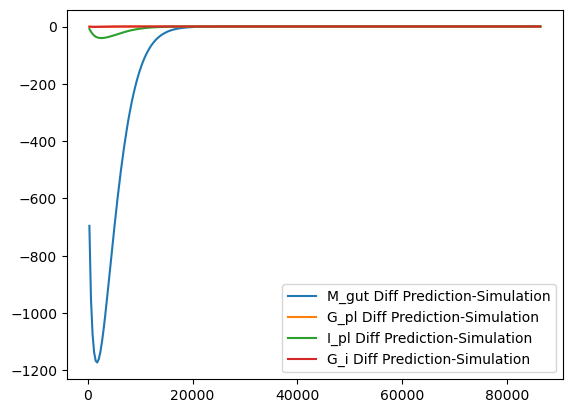

In [81]:
#Überprüfen, wie gross der Unterschied zwischen Simulation und Vorhersage ist
plt.plot(sim_data_a[:,0], x_pred_a[:,0]-sim_4[:,0], label = "M_gut Diff Prediction-Simulation")
plt.plot(sim_data_a[:,0], x_pred_a[:,1]-sim_4[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(sim_data_a[:,0], x_pred_a[:,2]-sim_4[:,2], label = "I_pl Diff Prediction-Simulation")
plt.plot(sim_data_a[:,0], x_pred_a[:,3]-sim_4[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

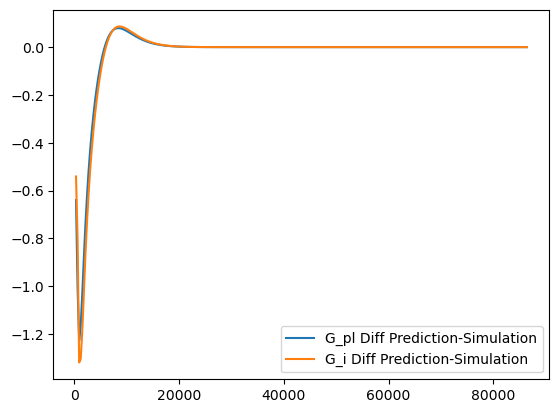

In [82]:
#Differenz Vorhersage zu Simulation nur Glukose-Vorhersagen
plt.plot(sim_data_a[:,0], x_pred_a[:,1]-sim_4[:,1], label = "G_pl Diff Prediction-Simulation")
plt.plot(sim_data_a[:,0], x_pred_a[:,3]-sim_4[:,3], label = "G_i Diff Prediction-Simulation")
plt.legend()

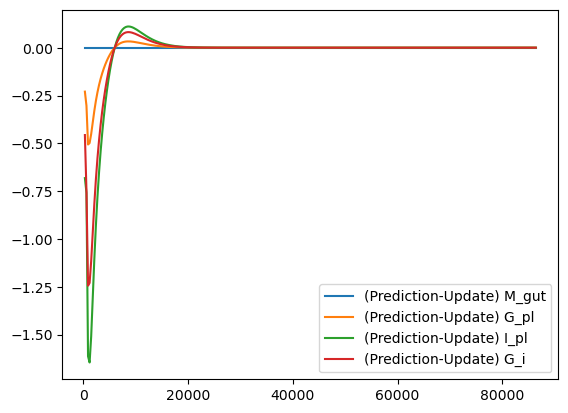

In [83]:
#Überprüfen ob UKF arbeitet
diff = x_pred_a - x_upd_a

plt.plot(sim_data_a[:, 0], diff[:, 0], label=f"(Prediction-Update) M_gut")
plt.plot(sim_data_a[:, 0], diff[:, 1], label=f"(Prediction-Update) G_pl")
plt.plot(sim_data_a[:, 0], diff[:, 2], label=f"(Prediction-Update) I_pl")
plt.plot(sim_data_a[:, 0], diff[:, 3], label=f"(Prediction-Update) G_i")

plt.legend()
plt.show()

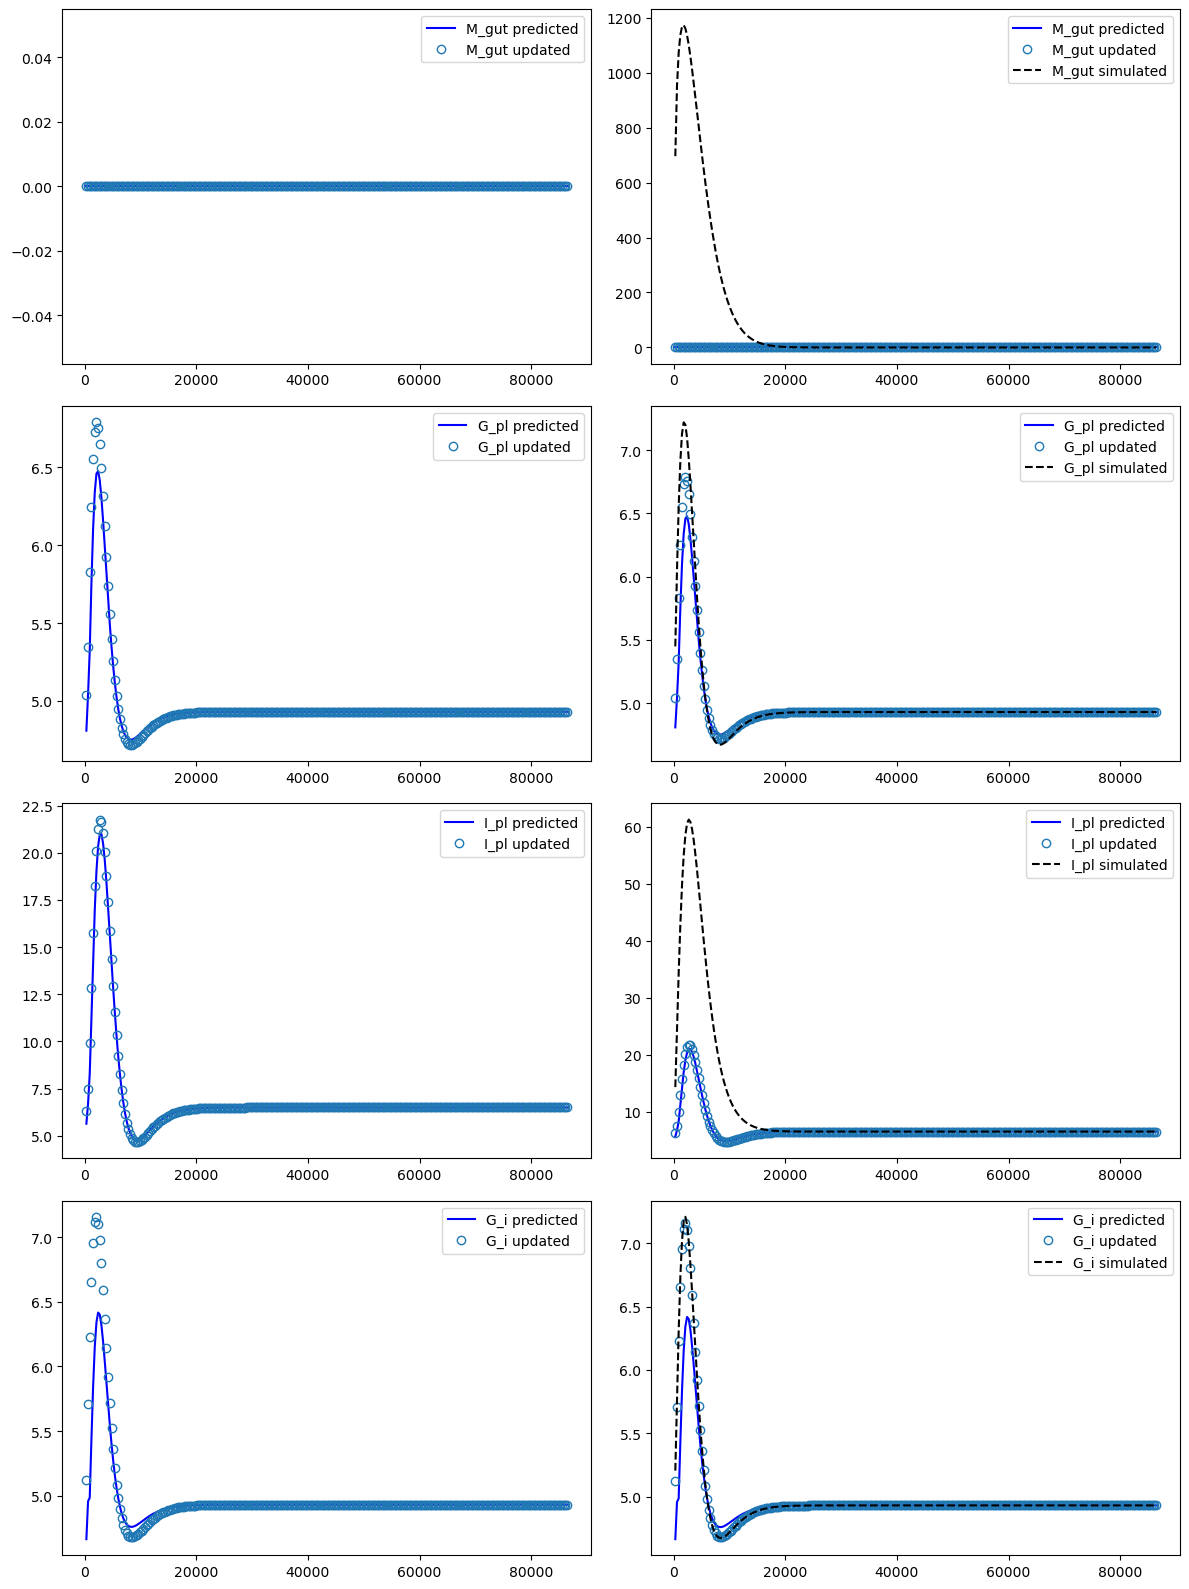

In [84]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(sim_data_a[:,0], x_pred_a[:,0], "b", label = "M_gut predicted")
ax[0,0].plot(sim_data_a[:,0], x_upd_a[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(sim_data_a[:,0], x_pred_a[:,0], "b", label = "M_gut predicted")
ax[0,1].plot(sim_data_a[:,0], x_upd_a[:,0], "o", mfc='none', label = "M_gut updated")
ax[0,1].plot(sim_data_a[:,0], sim[:,0], "k--", label = "M_gut simulated")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(sim_data_a[:,0], x_pred_a[:,1], "b", label = "G_pl predicted")
ax[1,0].plot(sim_data_a[:,0], x_upd_a[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(sim_data_a[:,0], x_pred_a[:,1], "b", label = "G_pl predicted")
ax[1,1].plot(sim_data_a[:,0], x_upd_a[:,1], "o", mfc='none', label = "G_pl updated")
ax[1,1].plot(sim_data_a[:,0], sim[:,1], "k--", label = "G_pl simulated")
ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(sim_data_a[:,0], x_pred_a[:,2], "b", label = "I_pl predicted")
ax[2,0].plot(sim_data_a[:,0], x_upd_a[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(sim_data_a[:,0], x_pred_a[:,2], "b", label = "I_pl predicted")
ax[2,1].plot(sim_data_a[:,0], x_upd_a[:,2], "o", mfc='none', label = "I_pl updated")
ax[2,1].plot(sim_data_a[:,0], sim[:,2], "k--", label = "I_pl simulated")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(sim_data_a[:,0], x_pred_a[:,3], "b", label = "G_i predicted")
ax[3,0].plot(sim_data_a[:,0], x_upd_a[:,3], "o", mfc='none', label = "G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[3,1].plot(sim_data_a[:,0], x_pred_a[:,3], "b", label = "G_i predicted")
ax[3,1].plot(sim_data_a[:,0], x_upd_a[:,3], "o", mfc='none', label = "G_i updated")
ax[3,1].plot(sim_data_a[:,0], sim[:,3], "k--", label = "G_i simulated")
ax[3,1].legend()


plt.tight_layout()

#### B) 4 Modellzustände, ein Mahlzeiteninput nach Ruhezeit

In [30]:
from Test_UKF_ode_mealtime import f_odes_Dt
from Test_UKF_solver_b import f_solve_b

In [31]:
t_eval = np.arange(1,86402,300) #Während 24h alle 5min. ein Zeitschritt --> eine Messung
D = 75000 #KH-Gehalt einer Mahlzeit

In [32]:
# Erzeugen eines Datensets mit verzögertem Mahlzeiteninput für simulierte Daten
D_in = np.zeros(len(t_eval))
D_in[13] = D #einfügen Mahlzeiteninput
simulation_input = np.column_stack((D_in, t_eval))

D_in_2 = np.zeros(len(t_eval))
D_in_2[26] = D
sim_input_2 = np.column_stack((D_in_2, t_eval))

D_in_3 = np.zeros(len(t_eval))
D_in_3[39] = D
sim_input_3 = np.column_stack((D_in_3, t_eval))

In [33]:
y_b = y_a #Startwerte übernehmen von Simulation A

In [34]:
sim_b = f_solve_b(f_odes_Dt, y_b, simulation_input)
sim_b2 = f_solve_b(f_odes_Dt, y_b, sim_input_2)
sim_b3 = f_solve_b(f_odes_Dt, y_b, sim_input_3)

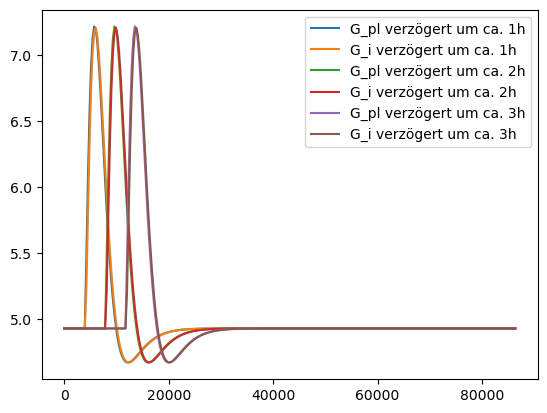

In [35]:
plt.plot(t_eval, sim_b[:,1], label = "G_pl verzögert um ca. 1h") #Simulierte Plasma-Glukose
plt.plot(t_eval, sim_b[:,3], label = "G_i verzögert um ca. 1h") #Simulierte Glukose im Interstitium

plt.plot(t_eval, sim_b2[:,1], label = "G_pl verzögert um ca. 2h")
plt.plot(t_eval, sim_b2[:,3], label = "G_i verzögert um ca. 2h")

plt.plot(t_eval, sim_b3[:,1], label = "G_pl verzögert um ca. 3h")
plt.plot(t_eval, sim_b3[:,3], label = "G_i verzögert um ca. 3h")

plt.legend()

In [36]:
sim_b[:,3]+=noise
sim_b2[:,3]+=noise
sim_b3[:,3]+=noise

#### UKF-Schätzung der simulierten Daten

In [37]:
from Test_UKF_ode_mealtime_ukf import f_odes_Dt_ukf

In [38]:
#Datensatz für UKF vorbereiten: 
# data_set_b[0]: Zeit in s, data_set_b[1]: simulierte CGM-Daten, data_set_b[2]: Mahlzeiteninputs

data_set_b = np.column_stack((t_eval, sim_b[:,3], D_in)) #Datensatz 1
data_set_b2 = np.column_stack((t_eval, sim_b2[:,3], D_in_2)) #Datensatz 2
data_set_b3 = np.column_stack((t_eval, sim_b3[:,3], D_in_3)) #Datensatz 3

In [39]:
#Datensatz 1 kürzen nach Verzögerung ca. 1h
mask_b = data_set_b[:,0] < 26000
data_set_b_short = data_set_b[mask_b]
t_current_b = data_set_b_short[:,0]
sim_b_short = sim_b[mask_b]

#Datensatz 2 kürzen nach Verzögerung ca. 2h
mask_b2 = data_set_b2[:,0] < 30000
data_set_b2_short = data_set_b2[mask_b2]
t_current_b2 = data_set_b2_short[:,0]
sim_b2_short = sim_b2[mask_b2]

#Datensatz 3 kürzen nach Verzögerung ca. 3h
mask_b3 = data_set_b3[:,0] < 34000
data_set_b3_short = data_set_b3[mask_b3]
t_current_b3 = data_set_b3_short[:,0]
sim_b3_short = sim_b3[mask_b3]

In [40]:
#Mahlzeitengrösse und Zeit auslesen Datensatz 1
mask_dmeal = data_set_b_short[:,2] > 0
D_meal_time = data_set_b_short[mask_dmeal]
D_meal_time = D_meal_time[:,[0,2]]

#Mahlzeitengrösse und Zeit auslesen Datensatz 2
mask_dmeal2 = data_set_b2_short[:,2] > 0
D_meal_time2 = data_set_b2_short[mask_dmeal2]
D_meal_time2 = D_meal_time2[:,[0,2]]

#Mahlzeitengrösse und Zeit auslesen Datensatz 3
mask_dmeal3 = data_set_b3_short[:,2] > 0
D_meal_time3 = data_set_b3_short[mask_dmeal3]
D_meal_time3 = D_meal_time3[:,[0,2]]

#Ausgabe prüfen
D_meal_time, D_meal_time2, D_meal_time3

(array([[ 3901., 75000.]]),
 array([[ 7801., 75000.]]),
 array([[11701., 75000.]]))

In [41]:
Q_b = np.diag([
    1e-4,   # M_gut
    5e-4,   # G_pl
    5e-5,   # I_pl
    5e-4,   # G_i
])

In [42]:
#Messrauschen
covar_b = np.diag([
    var_M_gut, #M_gut
    var_G_pl, #G_pl
    var_I_pl, #I_pl
    var_G_i, #G_i 
])

In [43]:
#Startwerte
y_b = np.array([0, #M_gut
                G_start, #G_pl
                I_start, #I_pl
                G_start, #G_i
               ]) 

In [44]:
def iterate_euler_b(y_in: np.ndarray, delta_t: float, inputs: tuple):
    '''Euler-Approximation der Integrationsfunktionen für EDES-Gleichungen'''
    t_current, D_meal = inputs
    y_next = np.zeros(len(y_in))
    dydt = f_odes_Dt_ukf(y_in, t_current, D_meal)
    y_next = y_in + dydt*delta_t
    return y_next

In [45]:
#num_states, process_noise, initial_state, initial_covar, alpha, k, beta, iterate_function
params_b = {
    "num_states" : 4,
    "process_noise" : Q_b,
    "initial_state" : y_b,
    "initial_covar" : covar_b,
    "alpha" : 1e-3, #Standardwert
    "k": 0, #Standardwert
    "beta" : 2.0, # Standardwert
    "iterate_function" : iterate_euler_b
}

In [46]:
#UKF für Datensatz 1
estimator_b = UKF(**params_b)
x_pred_b = np.zeros((len(data_set_b_short),4))
x_upd_b = np.zeros((len(data_set_b_short),4))

In [47]:
#UKF für Datensatz 2
estimator_b2 = UKF(**params_b)
x_pred_b2 = np.zeros((len(data_set_b2_short),4))
x_upd_b2 = np.zeros((len(data_set_b2_short),4))

In [48]:
#UKF für Datensatz 3
estimator_b3 = UKF(**params_b)
x_pred_b3 = np.zeros((len(data_set_b3_short),4))
x_upd_b3 = np.zeros((len(data_set_b3_short),4))

In [49]:
#Schrittgrösse
step_b = 1

In [50]:
#Schätzen Zustande mit Datensatz 1
for i, row in enumerate(data_set_b_short):
    t_current_b = row[0] #simulierte Zeit
    inputs = (t_current_b, D_meal_time) #D_meal_time[0] = Zeit D_i, D_meal_time[1] = D_meal
    cgm = row[1] #simulierte CGM_Daten
    
    estimator_b.predict(step_b, inputs)
    x_pred_b[i] = estimator_b.get_state()
    estimator_b.update([3], cgm, covar_a[3,3])
    x_upd_b[i] = estimator_b.get_state()

In [51]:
#Schätzen Zustande mit Datensatz 2
for i, row in enumerate(data_set_b2_short):
    t_current_b2 = row[0] #simulierte Zeit
    inputs2 = (t_current_b2, D_meal_time2) #D_meal_time[0] = Zeit D_i, D_meal_time[1] = D_meal
    cgm2 = row[1] #simulierte CGM_Daten
    
    estimator_b2.predict(step_b, inputs2)
    x_pred_b2[i] = estimator_b2.get_state()
    estimator_b2.update([3], cgm2, covar_a[3,3])
    x_upd_b2[i] = estimator_b2.get_state()

In [52]:
#Schätzen Zustande mit Datensatz 3
for i, row in enumerate(data_set_b3_short):
    t_current_b3 = row[0] #simulierte Zeit
    inputs3 = (t_current_b3, D_meal_time3) #D_meal_time[0] = Zeit D_i, D_meal_time[1] = D_meal
    cgm3 = row[1] #simulierte CGM_Daten
    
    estimator_b3.predict(step_b, inputs3)
    x_pred_b3[i] = estimator_b3.get_state()
    estimator_b3.update([3], cgm3, covar_a[3,3])
    x_upd_b3[i] = estimator_b3.get_state()

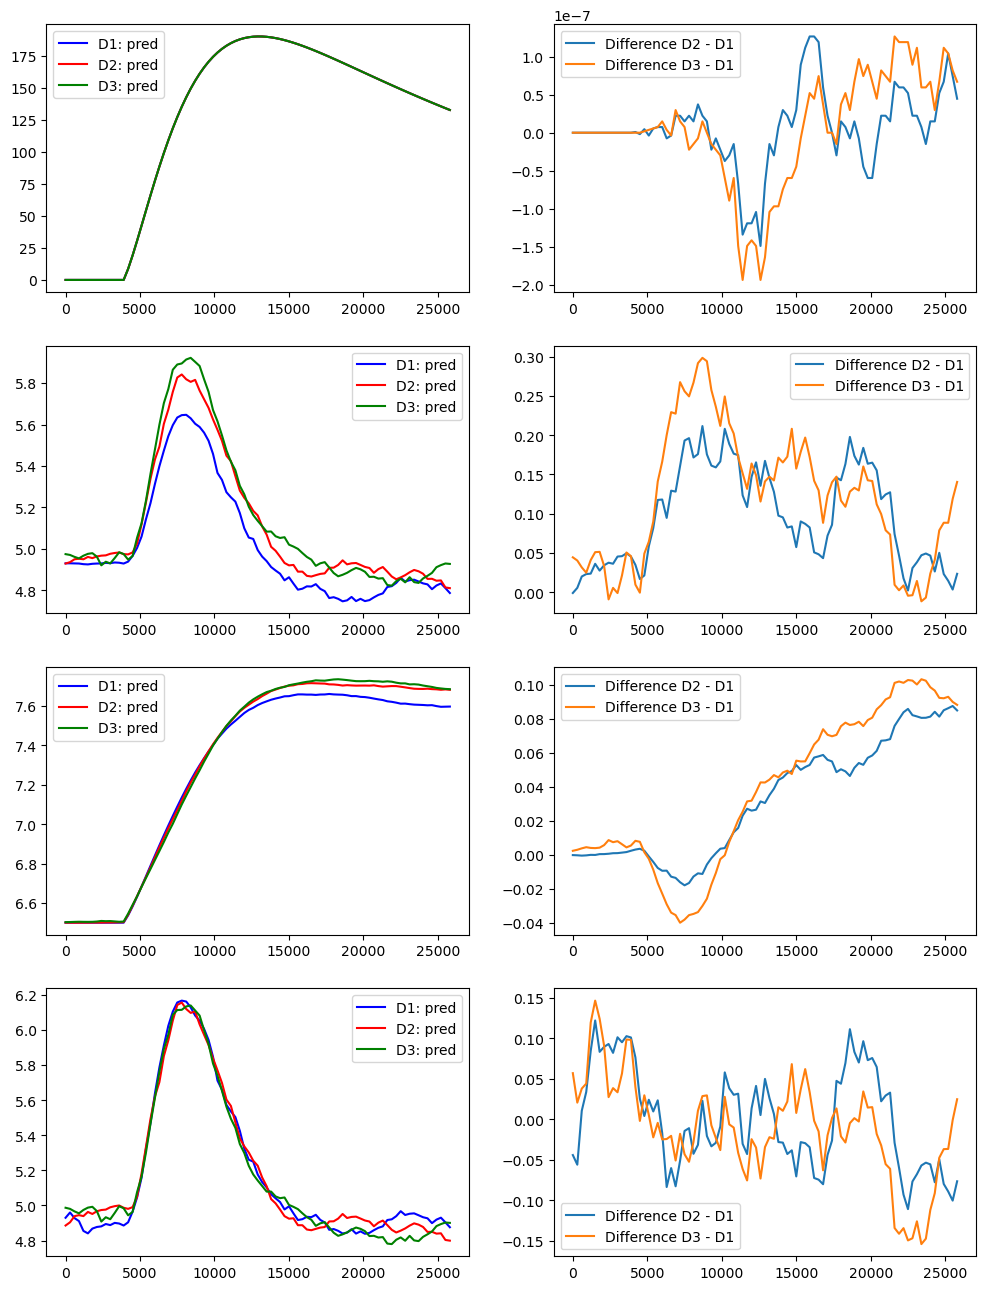

In [53]:
#Differenz Schätzung D1 vs Schätzung D2
offset = 26-13
data_set_b2_short_aligned = data_set_b2_short[offset:]
x_pred_b2_aligned = x_pred_b2[offset:]

offset2 = 39-13
data_set_b3_short_aligned = data_set_b3_short[offset2:][:-1]
x_pred_b3_aligned = x_pred_b3[offset2:][:-1]


fig, ax = plt.subplots(4,2, figsize = (12, 16))

for col in range(x_pred_b.shape[1]):  
    ax[col,0].plot(data_set_b_short[:,0], x_pred_b[:, col], "b", label = "D1: pred")
    ax[col,0].plot(data_set_b2_short_aligned[:,0]-offset*300, x_pred_b2_aligned[:,col], "r", label = "D2: pred")
    ax[col,0].plot(data_set_b3_short_aligned[:,0]-offset2*300, x_pred_b3_aligned[:,col], "g", label = "D3: pred")
    ax[col,0].legend()

    ax[col,1].plot(data_set_b_short[:,0], x_pred_b2_aligned[:,col]-x_pred_b[:,col], label = "Difference D2 - D1")
    ax[col,1].plot(data_set_b3_short_aligned[:,0]-offset2*300, x_pred_b3_aligned[:,col]-x_pred_b[:,col], label = "Difference D3 - D1")
    ax[col,1].legend()

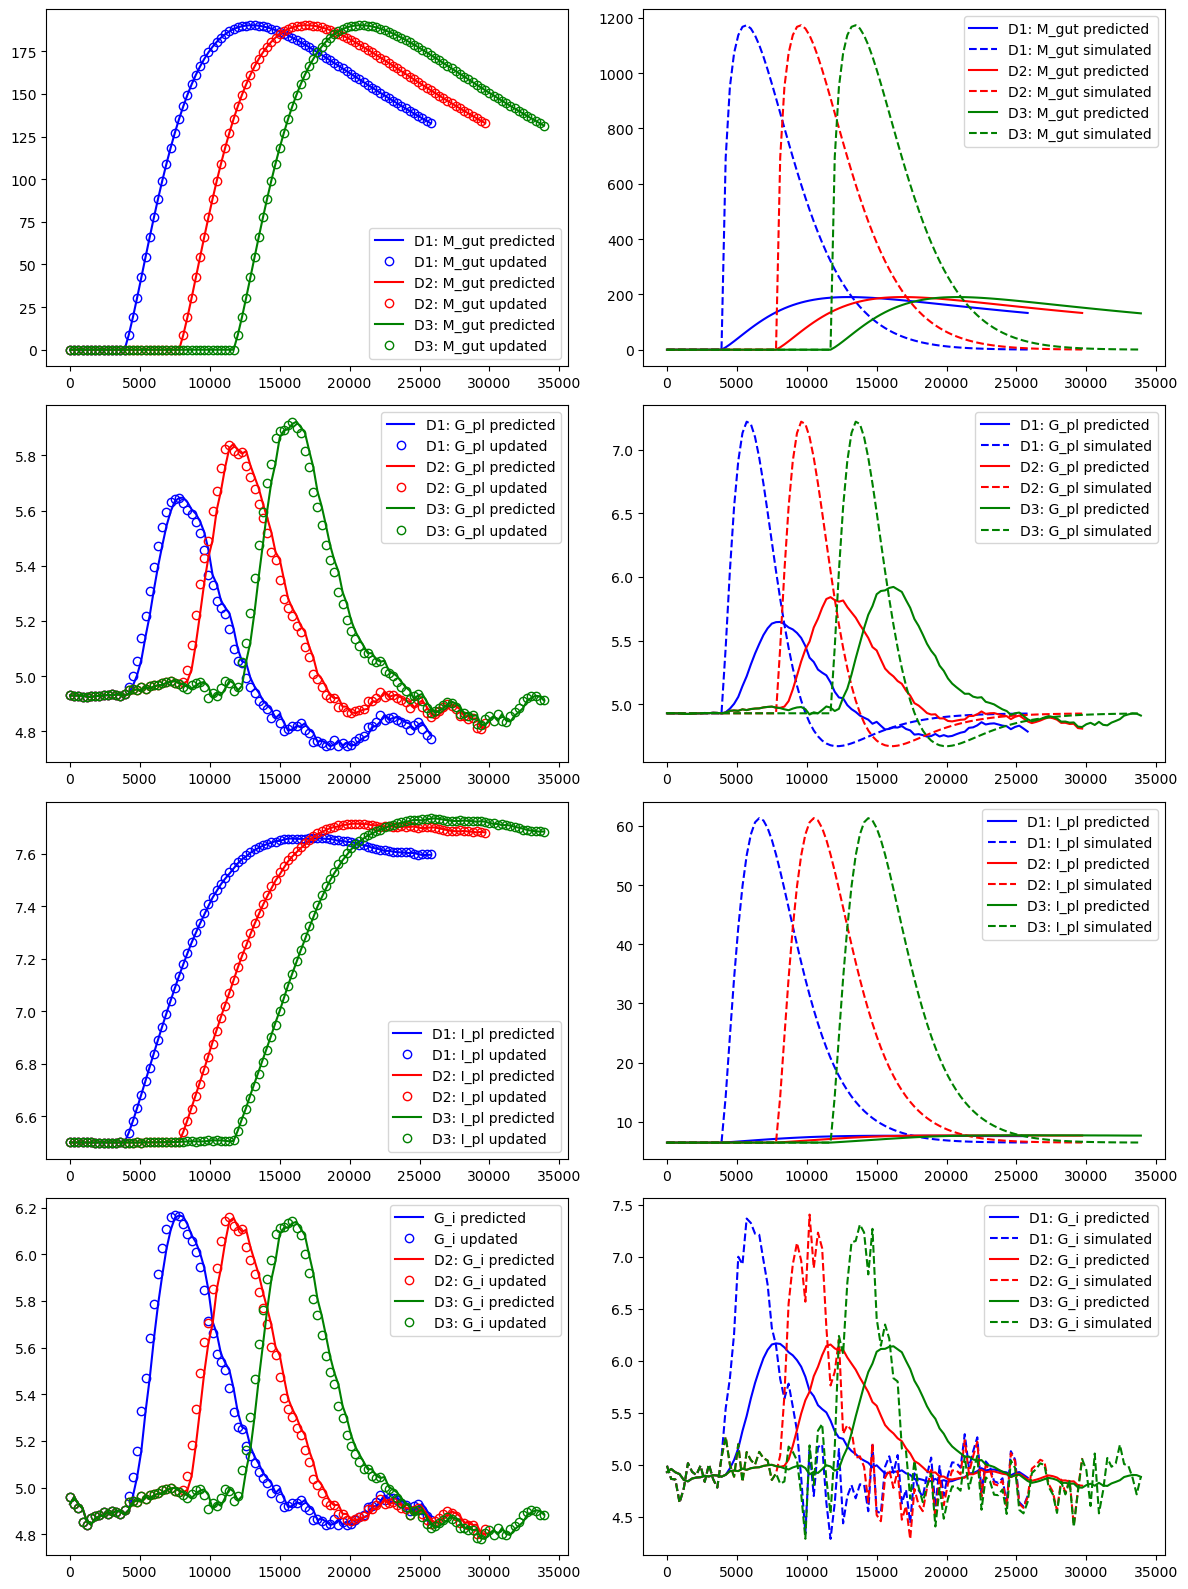

In [54]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(data_set_b_short[:,0], x_pred_b[:,0], "b",label = "D1: M_gut predicted")
ax[0,0].plot(data_set_b_short[:,0], x_upd_b[:,0], "ob", mfc='none', label = "D1: M_gut updated")
ax[0,0].plot(data_set_b2_short[:,0], x_pred_b2[:,0], "r",label = "D2: M_gut predicted")
ax[0,0].plot(data_set_b2_short[:,0], x_upd_b2[:,0], "or", mfc='none', label = "D2: M_gut updated")
ax[0,0].plot(data_set_b3_short[:,0], x_pred_b3[:,0], "g", label = "D3: M_gut predicted")
ax[0,0].plot(data_set_b3_short[:,0], x_upd_b3[:,0], "og", mfc='none', label = "D3: M_gut updated")
ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(data_set_b_short[:,0], x_pred_b[:,0], "b", label = "D1: M_gut predicted")
#ax[0,1].plot(data_set_b_short[:,0], x_upd_b[:,0], "ob", mfc='none', label = "D1: M_gut updated")
ax[0,1].plot(data_set_b_short[:,0], sim_b_short[:,0], "b--", label = "D1: M_gut simulated")
ax[0,1].plot(data_set_b2_short[:,0], x_pred_b2[:,0], "r", label = "D2: M_gut predicted")
#ax[0,1].plot(data_set_b2_short[:,0], x_upd_b2[:,0], "or", mfc='none', label = "D2: M_gut updated")
ax[0,1].plot(data_set_b2_short[:,0], sim_b2_short[:,0], "r--", label = "D2: M_gut simulated")
ax[0,1].plot(data_set_b3_short[:,0], x_pred_b3[:,0], "g", label = "D3: M_gut predicted")
#ax[0,1].plot(data_set_b3_short[:,0], x_upd_b3[:,0], "og", mfc='none', label = "D3: M_gut updated")
ax[0,1].plot(data_set_b3_short[:,0], sim_b3_short[:,0], "g--", label = "D3: M_gut simulated")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(data_set_b_short[:,0], x_pred_b[:,1], "b", label = "D1: G_pl predicted")
ax[1,0].plot(data_set_b_short[:,0], x_upd_b[:,1], "ob", mfc='none', label = "D1: G_pl updated")
ax[1,0].plot(data_set_b2_short[:,0], x_pred_b2[:,1], "r", label = "D2: G_pl predicted")
ax[1,0].plot(data_set_b2_short[:,0], x_upd_b2[:,1], "or", mfc='none', label = "D2: G_pl updated")
ax[1,0].plot(data_set_b3_short[:,0], x_pred_b3[:,1], "g", label = "D3: G_pl predicted")
ax[1,0].plot(data_set_b3_short[:,0], x_upd_b3[:,1], "og", mfc='none', label = "D3: G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(data_set_b_short[:,0], x_pred_b[:,1], "b", label = "D1: G_pl predicted")
#ax[1,1].plot(data_set_b_short[:,0], x_upd_b[:,1], "ob", mfc='none', label = "D1: G_pl updated")
ax[1,1].plot(data_set_b_short[:,0], sim_b_short[:,1], "b--", label = "D1: G_pl simulated")
ax[1,1].plot(data_set_b2_short[:,0], x_pred_b2[:,1], "r", label = "D2: G_pl predicted")
#ax[1,1].plot(data_set_b2_short[:,0], x_upd_b2[:,1], "or", mfc='none', label = "D2: G_pl updated")
ax[1,1].plot(data_set_b2_short[:,0], sim_b2_short[:,1], "r--", label = "D2: G_pl simulated")
ax[1,1].plot(data_set_b3_short[:,0], x_pred_b3[:,1], "g", label = "D3: G_pl predicted")
#ax[1,1].plot(data_set_b3_short[:,0], x_upd_b3[:,1], "og", mfc='none', label = "D3: G_pl updated")
ax[1,1].plot(data_set_b3_short[:,0], sim_b3_short[:,1], "g--", label = "D3: G_pl simulated")

ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(data_set_b_short[:,0], x_pred_b[:,2], "b", label = "D1: I_pl predicted")
ax[2,0].plot(data_set_b_short[:,0], x_upd_b[:,2], "ob", mfc='none', label = "D1: I_pl updated")
ax[2,0].plot(data_set_b2_short[:,0], x_pred_b2[:,2], "r", label = "D2: I_pl predicted")
ax[2,0].plot(data_set_b2_short[:,0], x_upd_b2[:,2], "or", mfc='none', label = "D2: I_pl updated")
ax[2,0].plot(data_set_b3_short[:,0], x_pred_b3[:,2], "g", label = "D3: I_pl predicted")
ax[2,0].plot(data_set_b3_short[:,0], x_upd_b3[:,2], "og", mfc='none', label = "D3: I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(data_set_b_short[:,0], x_pred_b[:,2], "b", label = "D1: I_pl predicted")
#ax[2,1].plot(data_set_b_short[:,0], x_upd_b[:,2], "ob", mfc='none', label = "D1: I_pl updated")
ax[2,1].plot(data_set_b_short[:,0], sim_b_short[:,2], "b--", label = "D1: I_pl simulated")
ax[2,1].plot(data_set_b2_short[:,0], x_pred_b2[:,2], "r", label = "D2: I_pl predicted")
#ax[2,1].plot(data_set_b2_short[:,0], x_upd_b2[:,2], "or", mfc='none', label = "D2: I_pl updated")
ax[2,1].plot(data_set_b2_short[:,0], sim_b2_short[:,2], "r--", label = "D2: I_pl simulated")
ax[2,1].plot(data_set_b3_short[:,0], x_pred_b3[:,2], "g", label = "D3: I_pl predicted")
#ax[2,1].plot(data_set_b3_short[:,0], x_upd_b3[:,2], "og", mfc='none', label = "D3: I_pl updated")
ax[2,1].plot(data_set_b3_short[:,0], sim_b3_short[:,2], "g--", label = "D3: I_pl simulated")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(data_set_b_short[:,0], x_pred_b[:,3], "b", label = "G_i predicted")
ax[3,0].plot(data_set_b_short[:,0], x_upd_b[:,3], "ob", mfc='none', label = "G_i updated")
ax[3,0].plot(data_set_b2_short[:,0], x_pred_b2[:,3], "r", label = "D2: G_i predicted")
ax[3,0].plot(data_set_b2_short[:,0], x_upd_b2[:,3], "or", mfc='none', label = "D2: G_i updated")
ax[3,0].plot(data_set_b3_short[:,0], x_pred_b3[:,3], "g", label = "D3: G_i predicted")
ax[3,0].plot(data_set_b3_short[:,0], x_upd_b3[:,3], "og", mfc='none', label = "D3: G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[3,1].plot(data_set_b_short[:,0], x_pred_b[:,3], "b", label = "D1: G_i predicted")
#ax[3,1].plot(data_set_b_short[:,0], x_upd_b[:,3], "ob", mfc='none', label = "D1: G_i updated")
ax[3,1].plot(data_set_b_short[:,0], sim_b_short[:,3], "b--", label = "D1: G_i simulated")
ax[3,1].plot(data_set_b2_short[:,0], x_pred_b2[:,3], "r", label = "D2: G_i predicted")
#ax[3,1].plot(data_set_b2_short[:,0], x_upd_b2[:,3], "or", mfc='none', label = "D2: G_i updated")
ax[3,1].plot(data_set_b2_short[:,0], sim_b2_short[:,3], "r--", label = "D2: G_i simulated")
ax[3,1].plot(data_set_b3_short[:,0], x_pred_b3[:,3], "g", label = "D3: G_i predicted")
#ax[3,1].plot(data_set_b3_short[:,0], x_upd_b3[:,3], "og", mfc='none', label = "D3: G_i updated")
ax[3,1].plot(data_set_b3_short[:,0], sim_b3_short[:,3], "g--", label = "D3: G_i simulated")
ax[3,1].legend()


plt.tight_layout()

#### Verzögerte Mahlzeit mit reduziertem Rauschen

Am "Besten" geschätzt wurde D3 --> bessere Grössenordnung von G_pl. 
Allerdings: Zeitliche Verzögerung des Peaks um ca. 15-20 Minuten, dasselbe auch bei G_i. Und Schätzungen für M_gut und I_pl unbrauchbar. //
Eine Überprüfung mit reduziertem Rauschen folgt mit D3

In [55]:
#Simulation mit verzögertem Mahlzeinteninput um 3h
sim_b3_n = f_solve_b(f_odes_Dt, y_b, sim_input_3)
sim_b3_n[:,3]+=noise2 #Datensatz mit verringertem Rauschen erstellen

In [56]:
#Datensatz 3_new erstellen für UKF, kürzen nach Verzögerung ca. 3h
data_set_b3_n = np.column_stack((t_eval, sim_b3_n[:,3], D_in_3)) #Datensatz 3_new mit verringertem Rauschen

mask_b3_n = data_set_b3_n[:,0] < 34000
data_set_b3_n_short = data_set_b3_n[mask_b3_n]
t_current_b3_n = data_set_b3_n_short[:,0]
sim_b3_n_short = sim_b3_n[mask_b3_n]

#Mahlzeitengrösse und Zeit auslesen
mask_dmeal3_n = data_set_b3_n_short[:,2] > 0
D_meal_time3_n = data_set_b3_n_short[mask_dmeal3_n]
D_meal_time3_n = D_meal_time3_n[:,[0,2]]
D_meal_time3_n

array([[11701., 75000.]])

In [57]:
#UKF für Datensatz 3_new
estimator_b3_n = UKF(**params_b)
x_pred_b3_n = np.zeros((len(data_set_b3_n_short),4))
x_upd_b3_n = np.zeros((len(data_set_b3_n_short),4))

In [58]:
step_b3_n = 1

In [59]:
#Schätzen Zustande mit Datensatz 3_new
for i, row in enumerate(data_set_b3_n_short):
    t_current_b3_n = row[0] #simulierte Zeit
    inputs3_n = (t_current_b3_n, D_meal_time3_n) #D_meal_time[0] = Zeit D_i, D_meal_time[1] = D_meal
    cgm3_n = row[1] #simulierte CGM_Daten
    
    estimator_b3_n.predict(step_b3_n, inputs3_n)
    x_pred_b3_n[i] = estimator_b3_n.get_state()
    estimator_b3_n.update([3], cgm3_n, covar_a[3,3])
    x_upd_b3_n[i] = estimator_b3_n.get_state()

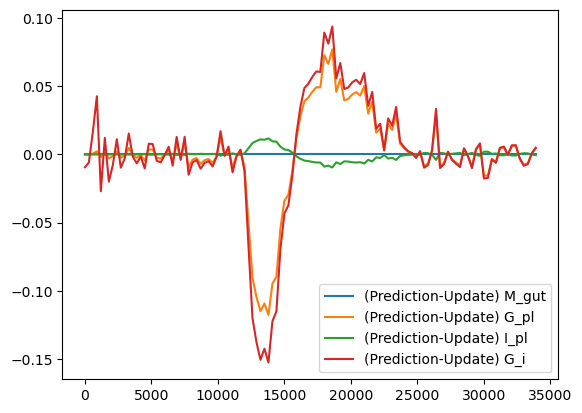

In [60]:
#Überprüfung ob UKF arbeitet --> Differenz Prediction vs Updated
diff3_n = x_pred_b3_n - x_upd_b3_n

plt.plot(data_set_b3_n_short[:, 0], diff3_n[:, 0], label=f"(Prediction-Update) M_gut")
plt.plot(data_set_b3_n_short[:, 0], diff3_n[:, 1], label=f"(Prediction-Update) G_pl")
plt.plot(data_set_b3_n_short[:, 0], diff3_n[:, 2], label=f"(Prediction-Update) I_pl")
plt.plot(data_set_b3_n_short[:, 0], diff3_n[:, 3], label=f"(Prediction-Update) G_i")

plt.legend()
plt.show()

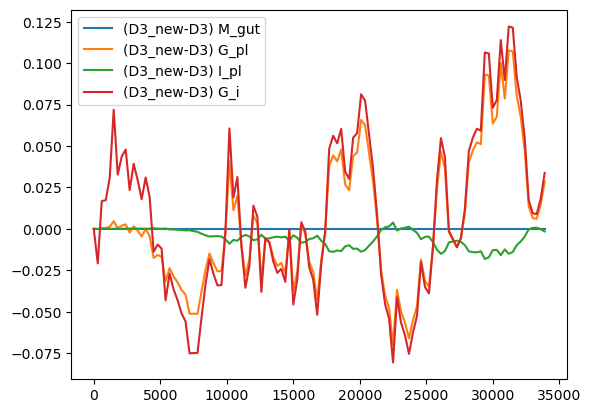

In [61]:
#Überprüfung wie gross Unterschied zwischen Datensatz D3 und D3_n ist

diff_d3_d3n = x_pred_b3_n-x_pred_b3

plt.plot(data_set_b3_n_short[:, 0], diff_d3_d3n[:, 0], label=f"(D3_new-D3) M_gut")
plt.plot(data_set_b3_n_short[:, 0], diff_d3_d3n[:, 1], label=f"(D3_new-D3) G_pl")
plt.plot(data_set_b3_n_short[:, 0], diff_d3_d3n[:, 2], label=f"(D3_new-D3) I_pl")
plt.plot(data_set_b3_n_short[:, 0], diff_d3_d3n[:, 3], label=f"(D3_new-D3) G_i")

plt.legend()
plt.show()

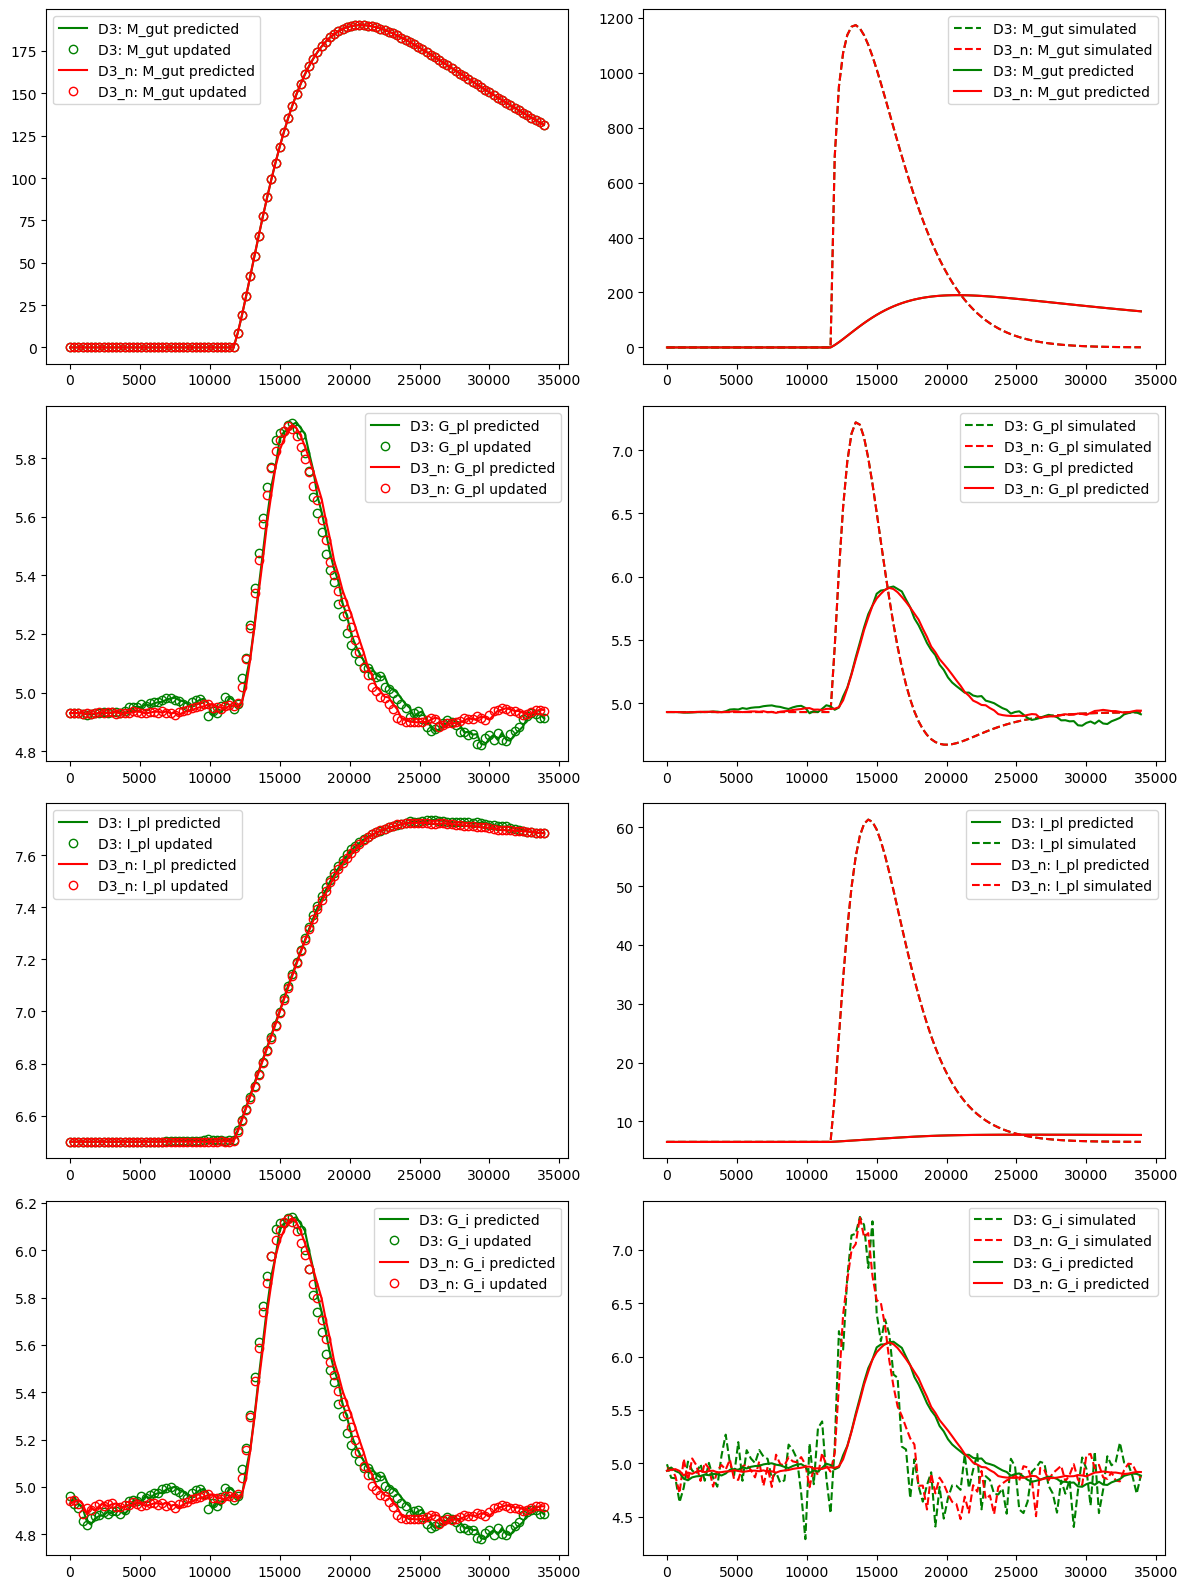

In [62]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(data_set_b3_short[:,0], x_pred_b3[:,0], "g", label = "D3: M_gut predicted")
ax[0,0].plot(data_set_b3_short[:,0], x_upd_b3[:,0], "og", mfc='none', label = "D3: M_gut updated")
ax[0,0].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,0], "r", label = "D3_n: M_gut predicted")
ax[0,0].plot(data_set_b3_n_short[:,0], x_upd_b3_n[:,0], "or", mfc='none', label = "D3_n: M_gut updated")

ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(data_set_b3_short[:,0], sim_b3_short[:,0], "g--", label = "D3: M_gut simulated")
ax[0,1].plot(data_set_b3_n_short[:,0], sim_b3_n_short[:,0], "r--", label = "D3_n: M_gut simulated")
ax[0,1].plot(data_set_b3_short[:,0], x_pred_b3[:,0], "g", label = "D3: M_gut predicted")
ax[0,1].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,0], "r", label = "D3_n: M_gut predicted")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(data_set_b3_short[:,0], x_pred_b3[:,1], "g", label = "D3: G_pl predicted")
ax[1,0].plot(data_set_b3_short[:,0], x_upd_b3[:,1], "og", mfc='none', label = "D3: G_pl updated")
ax[1,0].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,1], "r", label = "D3_n: G_pl predicted")
ax[1,0].plot(data_set_b3_n_short[:,0], x_upd_b3_n[:,1], "or", mfc='none', label = "D3_n: G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(data_set_b3_short[:,0], sim_b3_short[:,1], "g--", label = "D3: G_pl simulated")
ax[1,1].plot(data_set_b3_n_short[:,0], sim_b3_n_short[:,1], "r--", label = "D3_n: G_pl simulated")
ax[1,1].plot(data_set_b3_short[:,0], x_pred_b3[:,1], "g", label = "D3: G_pl predicted")
ax[1,1].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,1], "r", label = "D3_n: G_pl predicted")

ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(data_set_b3_short[:,0], x_pred_b3[:,2], "g", label = "D3: I_pl predicted")
ax[2,0].plot(data_set_b3_short[:,0], x_upd_b3[:,2], "og", mfc='none', label = "D3: I_pl updated")
ax[2,0].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,2], "r", label = "D3_n: I_pl predicted")
ax[2,0].plot(data_set_b3_n_short[:,0], x_upd_b3_n[:,2], "or", mfc='none', label = "D3_n: I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(data_set_b3_short[:,0], x_pred_b3[:,2], "g", label = "D3: I_pl predicted")
ax[2,1].plot(data_set_b3_short[:,0], sim_b3_short[:,2], "g--", label = "D3: I_pl simulated")
ax[2,1].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,2], "r", label = "D3_n: I_pl predicted")
ax[2,1].plot(data_set_b3_n_short[:,0], sim_b3_n_short[:,2], "r--", label = "D3_n: I_pl simulated")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(data_set_b3_short[:,0], x_pred_b3[:,3], "g", label = "D3: G_i predicted")
ax[3,0].plot(data_set_b3_short[:,0], x_upd_b3[:,3], "og", mfc='none', label = "D3: G_i updated")
ax[3,0].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,3], "r", label = "D3_n: G_i predicted")
ax[3,0].plot(data_set_b3_n_short[:,0], x_upd_b3_n[:,3], "or", mfc='none', label = "D3_n: G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[3,1].plot(data_set_b3_short[:,0], sim_b3_short[:,3], "g--", label = "D3: G_i simulated")
ax[3,1].plot(data_set_b3_n_short[:,0], sim_b3_n_short[:,3], "r--", label = "D3_n: G_i simulated")
ax[3,1].plot(data_set_b3_short[:,0], x_pred_b3[:,3], "g", label = "D3: G_i predicted")
ax[3,1].plot(data_set_b3_n_short[:,0], x_pred_b3_n[:,3], "r", label = "D3_n: G_i predicted")
ax[3,1].legend()


plt.tight_layout()

Kein relevanter unterschied ersichtlich zwischen den beiden Versionen von noise, abgesehen davon, dass simulierte Kurve etwas ähnlicher aussieht wie Originalkurven von Frau A. Schätzung weder in Grössenordnung noch Timing des Peaks besser geworden.

#### Mehrere Glukose-Impulse

In [63]:
# Erzeugen eines Datensets mit verzögertem Mahlzeiteninput für simulierte Daten
D_in_mult = np.zeros(len(t_eval))
D_in_mult[37] = D #einfügen Mahlzeiteninput
D_in_mult[85] = D
D_in_mult[133] = D
simulation_input = np.column_stack((D_in, t_eval))

In [64]:
test_mult_meals = f_solve_b(f_odes_Dt, y_b, simulation_input)

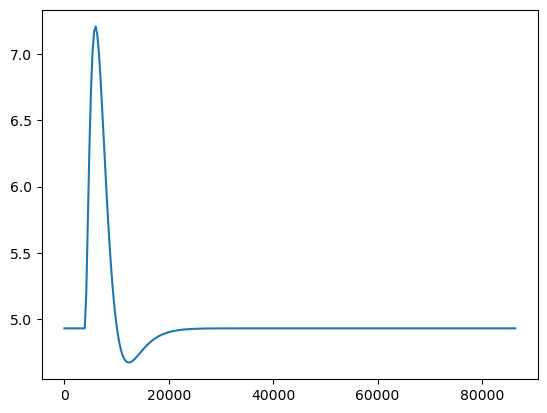

In [65]:
#Vorschau mehrere Mahlzeiten, Abstand 12h
plt.plot(t_eval, test_mult_meals[:,3])

In [66]:
#Rauschen hinzufügen
sim_mult_meals = test_mult_meals
sim_mult_meals[:,3] += noise

In [67]:
#Datensatz für UKF
data_mult = np.column_stack((t_eval, sim_mult_meals[:,3], D_in_mult))

In [68]:
#Mahlzeitengrösse und Zeit auslesen
mask_mult_meal = D_in_mult > 0
D_mult_meal = data_mult[mask_mult_meal]
D_mult_meal = D_mult_meal[:,[0,2]]
D_mult_meal

array([[11101., 75000.],
       [25501., 75000.],
       [39901., 75000.]])

In [69]:
#UKF für Datensatz 3_new
estimator_mult = UKF(**params_b)
x_pred_mult = np.zeros((len(data_mult),4))
x_upd_mult = np.zeros((len(data_mult),4))

In [70]:
step_mult = 1

In [71]:
#Schätzen Zustande mit Datensatz 3_new
for i, row in enumerate(data_mult):
    t_current_mult = row[0] #simulierte Zeit
    inputs_mult = (t_current_mult, D_mult_meal) #D_meal_time[0] = Zeit D_i, D_meal_time[1] = D_meal
    cgm_mult = row[1] #simulierte CGM_Daten
    
    estimator_mult.predict(step_mult, inputs_mult)
    x_pred_mult[i] = estimator_mult.get_state()
    estimator_mult.update([3], cgm_mult, covar_b[3,3])
    x_upd_mult[i] = estimator_mult.get_state()

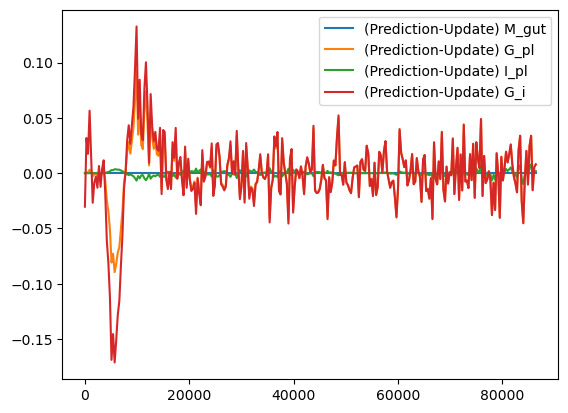

In [72]:
#Überprüfung ob UKF arbeitet --> Differenz Prediction vs Updated
diff_mult = x_pred_mult - x_upd_mult

plt.plot(data_mult[:, 0], diff_mult[:, 0], label=f"(Prediction-Update) M_gut")
plt.plot(data_mult[:, 0], diff_mult[:, 1], label=f"(Prediction-Update) G_pl")
plt.plot(data_mult[:, 0], diff_mult[:, 2], label=f"(Prediction-Update) I_pl")
plt.plot(data_mult[:, 0], diff_mult[:, 3], label=f"(Prediction-Update) G_i")

plt.legend()
plt.show()

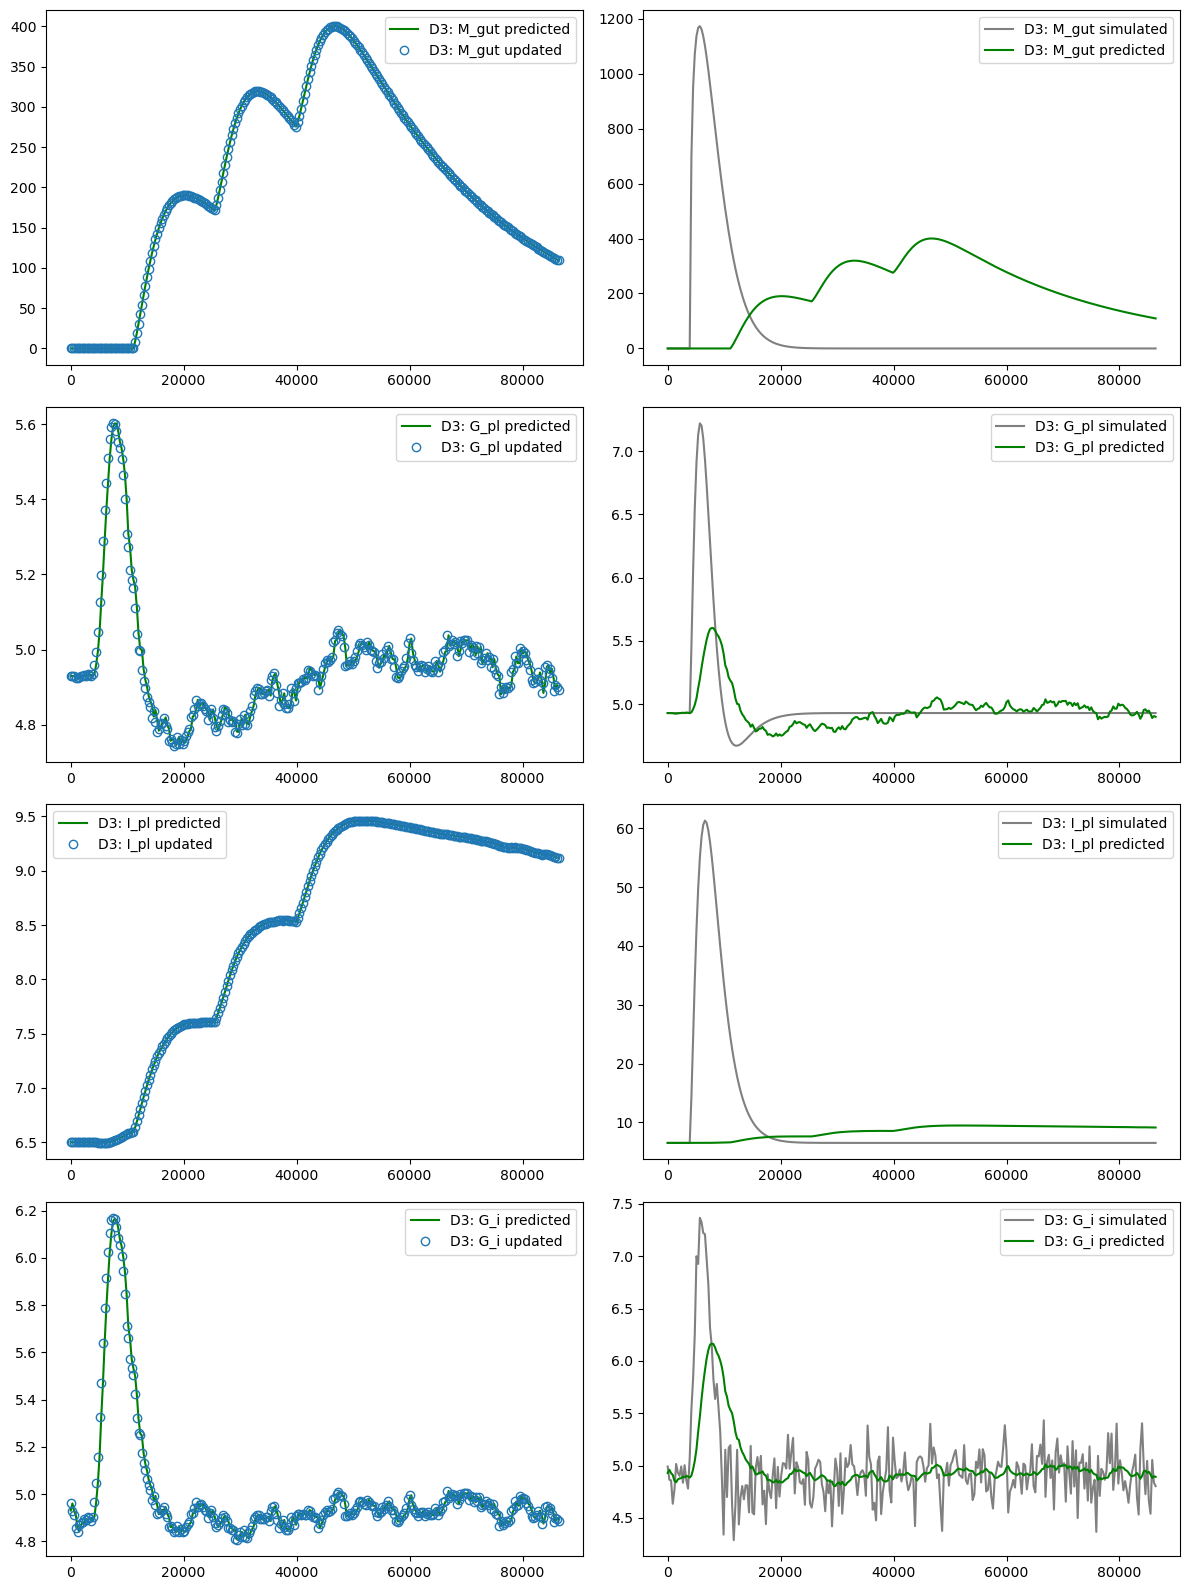

In [73]:
fig, ax = plt.subplots(4,2, figsize = (12, 16))

#UKF Magen/Darm
ax[0,0].plot(data_mult[:,0], x_pred_mult[:,0], "g", label = "D3: M_gut predicted")
ax[0,0].plot(data_mult[:,0], x_upd_mult[:,0], "o", mfc='none', label = "D3: M_gut updated")
ax[0,0].legend()

#Simulation vs UKF - Magen/Darm
ax[0,1].plot(data_mult[:,0], sim_mult_meals[:,0], "grey", label = "D3: M_gut simulated")
ax[0,1].plot(data_mult[:,0], x_pred_mult[:,0], "g", label = "D3: M_gut predicted")
ax[0,1].legend()

#UKF Glukose Blut-Plasma
ax[1,0].plot(data_mult[:,0], x_pred_mult[:,1], "g", label = "D3: G_pl predicted")
ax[1,0].plot(data_mult[:,0], x_upd_mult[:,1], "o", mfc='none', label = "D3: G_pl updated")
ax[1,0].legend()

#Simulation vs UKF - Glukose im Blut-Plasma
ax[1,1].plot(data_mult[:,0], sim_mult_meals[:,1], "grey", label = "D3: G_pl simulated")
ax[1,1].plot(data_mult[:,0], x_pred_mult[:,1], "g", label = "D3: G_pl predicted")
ax[1,1].legend()

#UKF Insulin Blut-Plasma
ax[2,0].plot(data_mult[:,0], x_pred_mult[:,2], "g", label = "D3: I_pl predicted")
ax[2,0].plot(data_mult[:,0], x_upd_mult[:,2], "o", mfc='none', label = "D3: I_pl updated")
ax[2,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[2,1].plot(data_mult[:,0], sim_mult_meals[:,2], "grey", label = "D3: I_pl simulated")
ax[2,1].plot(data_mult[:,0], x_pred_mult[:,2], "g", label = "D3: I_pl predicted")
ax[2,1].legend()

#UKF Glukose Interstitium
ax[3,0].plot(data_mult[:,0], x_pred_mult[:,3], "g", label = "D3: G_i predicted")
ax[3,0].plot(data_mult[:,0], x_upd_mult[:,3], "o", mfc='none', label = "D3: G_i updated")
ax[3,0].legend()

#Simulation vs UKF - Insulin im Blut-Plasma
ax[3,1].plot(data_mult[:,0], sim_mult_meals[:,3], "grey", label = "D3: G_i simulated")
ax[3,1].plot(data_mult[:,0], x_pred_mult[:,3], "g", label = "D3: G_i predicted")
ax[3,1].legend()


plt.tight_layout()